Model Evaluation and Comparison:

- Use different evaluation metrics such as accuracy, precision, recall, and F1-score to assess the performance of the models.
- Compare the performance of the different models on both tasks, isCancerous and cell-type classification.
- Explore the use of the extra data provided in the Dataset_extra to improve the performance of the cell-type classification model and compare the results with the model trained on the main dataset.

Visualization:
- Visualize the classification results using confusion matrices, ROC curves, and precision-recall curves.
- Use activation maps or saliency maps to visualize the regions of the images that are important for the classification decision.

In [27]:
import sys

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
AUTOTUNE = tf.data.experimental.AUTOTUNE

sys.path.append('../../src')

In [2]:
dataset_main = pd.read_csv("../data/raw/data_labels_mainData.csv")
dataset_extra = pd.read_csv("../data/raw/data_labels_extraData.csv")

In [3]:
X_train, X_test = train_test_split(dataset_main, test_size = 0.2, random_state = 1)
X_train, X_val = train_test_split(X_train, test_size = 0.25, random_state = 1)

In [4]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_Val:", X_val.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (5937, 6)
Shape of X_Val: (1979, 6)
Shape of X_test: (1980, 6)


In [5]:
X_train

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
7364,1371,47,1371.png,inflammatory,1,0
5723,11364,32,11364.png,epithelial,2,1
7374,1381,47,1381.png,others,3,0
5479,11844,30,11844.png,epithelial,2,1
5282,17143,29,17143.png,inflammatory,1,0
...,...,...,...,...,...,...
5166,17019,29,17019.png,inflammatory,1,0
3466,1152,19,1152.png,epithelial,2,1
9883,1613,60,1613.png,epithelial,2,1
5173,17026,29,17026.png,inflammatory,1,0


In [6]:
X_val

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
7550,737,48,737.png,inflammatory,1,0
1810,13557,10,13557.png,epithelial,2,1
9083,12091,55,12091.png,others,3,0
9380,21092,57,21092.png,fibroblast,0,0
266,18672,4,18672.png,inflammatory,1,0
...,...,...,...,...,...,...
8119,3463,51,3463.png,epithelial,2,1
5105,16956,29,16956.png,inflammatory,1,0
5045,16889,29,16889.png,inflammatory,1,0
6342,8101,40,8101.png,inflammatory,1,0


In [7]:
X_train['isCancerous'] = X_train['isCancerous'].astype('str')
X_val['isCancerous'] = X_val['isCancerous'].astype('str')

In [8]:
train_image = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_image = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_image.flow_from_dataframe(
        dataframe=X_train,
        directory='../data/raw/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_image.flow_from_dataframe(
        dataframe=X_val,
        directory='../data/raw/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.


In [9]:
input_dim = (27, 27, 3)
hidden_layer_dim = 256
output_classes = 2

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dim),
    tf.keras.layers.Dense(hidden_layer_dim, activation='sigmoid'),
    tf.keras.layers.Dense(output_classes)
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 256)               560128    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________


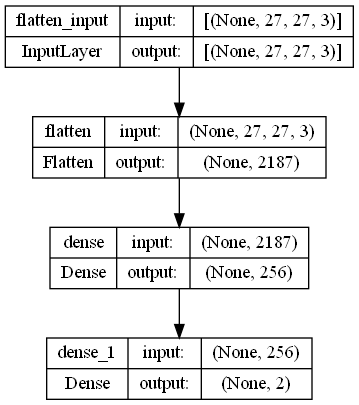

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [13]:
model.compile(optimizer='SGD', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [14]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

In [15]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

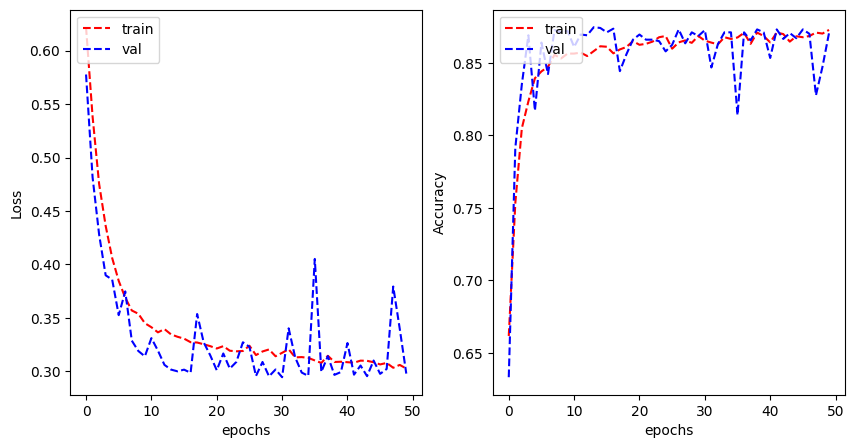

In [16]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [17]:
y_prediction = model.predict(validation_generator)
y_prediction = np.argmax (y_prediction, axis = 1)

74/74 [==============================] - 1s 8ms/step


In [21]:
y_prediction

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [24]:
y_test = X_val['isCancerous'].to_numpy(dtype="int64")

In [25]:
y_test

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

In [26]:
result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(result)

[[0.60269058 0.57060185]
 [0.39730942 0.42939815]]


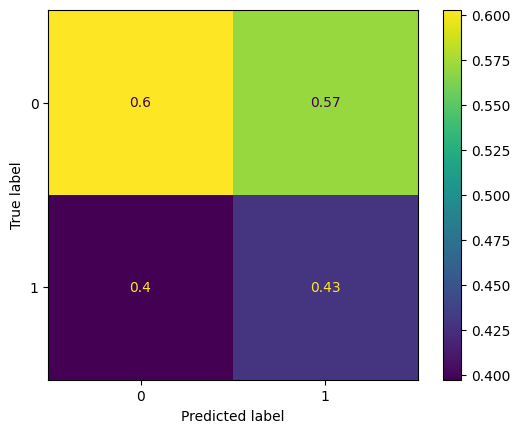

In [33]:
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=[0, 1])
disp.plot()
plt.show()